# Human Activity Recognition — Course Project

Authors: girdauskaite + partner

This notebook assumes you already have separate train and test CSV files (no internal random split). It covers loading, aligning features, preprocessing (fit on train, apply to test), baseline models, required models (RandomForest, XGBoost), additional methods (CatBoost, k-NN), hyperparameter tuning templates, ablation experiments, interpretation (SHAP), and model saving.

Run cells sequentially. Edit paths and parameters where noted.

## 0) Environment / Install packages (run once)

Uncomment and run the pip install line if packages are missing in your environment.

In [33]:
# !pip install xgboost catboost shap tensorflow scikit-learn seaborn matplotlib joblib
# Uncomment above line to install missing packages.

## 1) Imports

In [34]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

import joblib
import warnings
warnings.filterwarnings('ignore')

print('imports done')

imports done


## 2) Config / Paths / Label mapping
Update file paths if needed.

In [35]:
TRAIN_CSV = 'C:\\Users\\ugneg\\Documents\\GitHub\\machine-learning-project\\data\\activity_train.csv'   # path to your train CSV
TEST_CSV  = 'C:\\Users\\ugneg\\Documents\\GitHub\\machine-learning-project\\data\\activity_test.csv'    # path to your test CSV

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}
RANDOM_STATE = 42
print('config ready')

config ready


## 3) Load train & test CSVs and quick checks

In [36]:
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)

print('train shape:', df_train.shape)
print('test shape :', df_test.shape)

print('\nTrain columns sample:')
display(df_train.columns[:40])
print('\nTest columns sample:')
display(df_test.columns[:40])

print('\nTrain label present?', 'activity' in df_train.columns)
print('Test label present?', 'activity' in df_test.columns)


train shape: (7767, 562)
test shape : (3162, 562)

Train columns sample:


Index(['tBodyAcc_Mean_1', 'tBodyAcc_Mean_2', 'tBodyAcc_Mean_3',
       'tBodyAcc_STD_1', 'tBodyAcc_STD_2', 'tBodyAcc_STD_3', 'tBodyAcc_Mad_1',
       'tBodyAcc_Mad_2', 'tBodyAcc_Mad_3', 'tBodyAcc_Max_1', 'tBodyAcc_Max_2',
       'tBodyAcc_Max_3', 'tBodyAcc_Min_1', 'tBodyAcc_Min_2', 'tBodyAcc_Min_3',
       'tBodyAcc_SMA_1', 'tBodyAcc_Energy_1', 'tBodyAcc_Energy_2',
       'tBodyAcc_Energy_3', 'tBodyAcc_IQR_1', 'tBodyAcc_IQR_2',
       'tBodyAcc_IQR_3', 'tBodyAcc_ropy_1', 'tBodyAcc_ropy_1.1',
       'tBodyAcc_ropy_1.2', 'tBodyAcc_ARCoeff_1', 'tBodyAcc_ARCoeff_2',
       'tBodyAcc_ARCoeff_3', 'tBodyAcc_ARCoeff_4', 'tBodyAcc_ARCoeff_5',
       'tBodyAcc_ARCoeff_6', 'tBodyAcc_ARCoeff_7', 'tBodyAcc_ARCoeff_8',
       'tBodyAcc_ARCoeff_9', 'tBodyAcc_ARCoeff_10', 'tBodyAcc_ARCoeff_11',
       'tBodyAcc_ARCoeff_12', 'tBodyAcc_Correlation_1',
       'tBodyAcc_Correlation_2', 'tBodyAcc_Correlation_3'],
      dtype='object')


Test columns sample:


Index(['tBodyAcc_Mean_1', 'tBodyAcc_Mean_2', 'tBodyAcc_Mean_3',
       'tBodyAcc_STD_1', 'tBodyAcc_STD_2', 'tBodyAcc_STD_3', 'tBodyAcc_Mad_1',
       'tBodyAcc_Mad_2', 'tBodyAcc_Mad_3', 'tBodyAcc_Max_1', 'tBodyAcc_Max_2',
       'tBodyAcc_Max_3', 'tBodyAcc_Min_1', 'tBodyAcc_Min_2', 'tBodyAcc_Min_3',
       'tBodyAcc_SMA_1', 'tBodyAcc_Energy_1', 'tBodyAcc_Energy_2',
       'tBodyAcc_Energy_3', 'tBodyAcc_IQR_1', 'tBodyAcc_IQR_2',
       'tBodyAcc_IQR_3', 'tBodyAcc_ropy_1', 'tBodyAcc_ropy_1.1',
       'tBodyAcc_ropy_1.2', 'tBodyAcc_ARCoeff_1', 'tBodyAcc_ARCoeff_2',
       'tBodyAcc_ARCoeff_3', 'tBodyAcc_ARCoeff_4', 'tBodyAcc_ARCoeff_5',
       'tBodyAcc_ARCoeff_6', 'tBodyAcc_ARCoeff_7', 'tBodyAcc_ARCoeff_8',
       'tBodyAcc_ARCoeff_9', 'tBodyAcc_ARCoeff_10', 'tBodyAcc_ARCoeff_11',
       'tBodyAcc_ARCoeff_12', 'tBodyAcc_Correlation_1',
       'tBodyAcc_Correlation_2', 'tBodyAcc_Correlation_3'],
      dtype='object')


Train label present? True
Test label present? True


## 4) Separate X / y and align columns
We will: (1) extract y from train (and test if present), (2) find intersection of features, (3) restrict both datasets to that intersection. This avoids missing/extra column problems.

In [37]:
if 'activity' not in df_train.columns:
    raise ValueError('Train CSV must contain `activity` column')

# original labels (keep for display / submission) as integers
y_train = df_train['activity'].astype(int).copy()
# ensure 1..12 display encoding: if labels start at 0 shift to 1..12
if int(y_train.min()) == 0:
    y_train = (y_train + 1).astype(int)

X_train = df_train.drop(columns=['activity'])

has_test_labels = 'activity' in df_test.columns
if has_test_labels:
    y_test = df_test['activity'].astype(int).copy()
    if int(y_test.min()) == 0:
        y_test = (y_test + 1).astype(int)
    X_test = df_test.drop(columns=['activity'])
else:
    y_test = None
    X_test = df_test.copy()

# internal 0-based labels for model training / libraries that expect 0..K-1
y_train_model = (y_train - 1).astype(int)
y_test_model = (y_test - 1).astype(int) if y_test is not None else None

train_cols = set(X_train.columns)
test_cols  = set(X_test.columns)
common_cols = sorted(list(train_cols & test_cols))
missing_in_test = sorted(list(train_cols - test_cols))
extra_in_test = sorted(list(test_cols - train_cols))

print('common cols:', len(common_cols))
print('missing_in_test (train->test):', len(missing_in_test))
print('extra_in_test (test->train):', len(extra_in_test))
if missing_in_test:
    print('Example missing in test:', missing_in_test[:10])
if extra_in_test:
    print('Example extra in test:', extra_in_test[:10])

# Restrict both to common columns (preserves same feature order)
X_train = X_train[common_cols].copy()
X_test  = X_test[common_cols].copy()
print('Aligned shapes ->', X_train.shape, X_test.shape)


common cols: 561
missing_in_test (train->test): 0
extra_in_test (test->train): 0
Aligned shapes -> (7767, 561) (3162, 561)


## 5) Drop constant columns (based on training set) and missing values check

In [38]:
const_cols = [c for c in X_train.columns if X_train[c].nunique() <= 1]
print('constant columns in train:', len(const_cols))
if const_cols:
    print(const_cols[:20])
    X_train.drop(columns=const_cols, inplace=True)
    X_test.drop(columns=const_cols, inplace=True)

na_cols_train = X_train.columns[X_train.isna().any()].tolist()
na_cols_test  = X_test.columns[X_test.isna().any()].tolist()
print('NaNs in train:', na_cols_train)
print('NaNs in test :', na_cols_test)

print('Final feature count:', X_train.shape[1])

constant columns in train: 0
NaNs in train: []
NaNs in test : []
Final feature count: 561


## 6) Quick EDA (class balance + sample feature histograms)
This is optional but helpful to understand distributions and class imbalance.

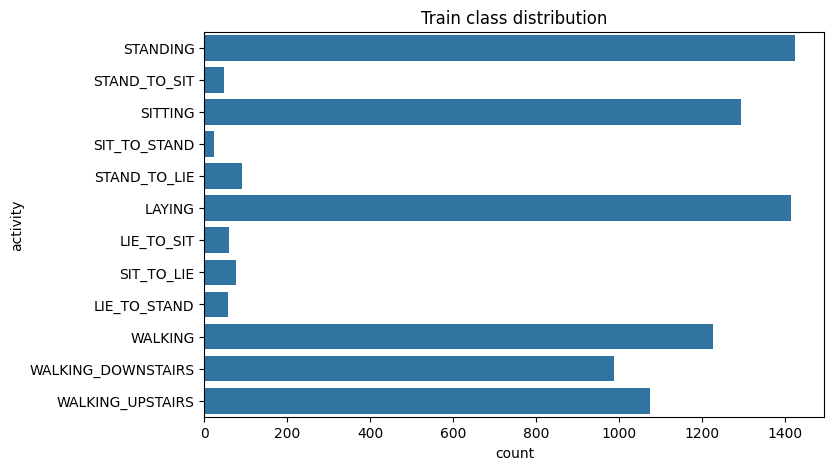

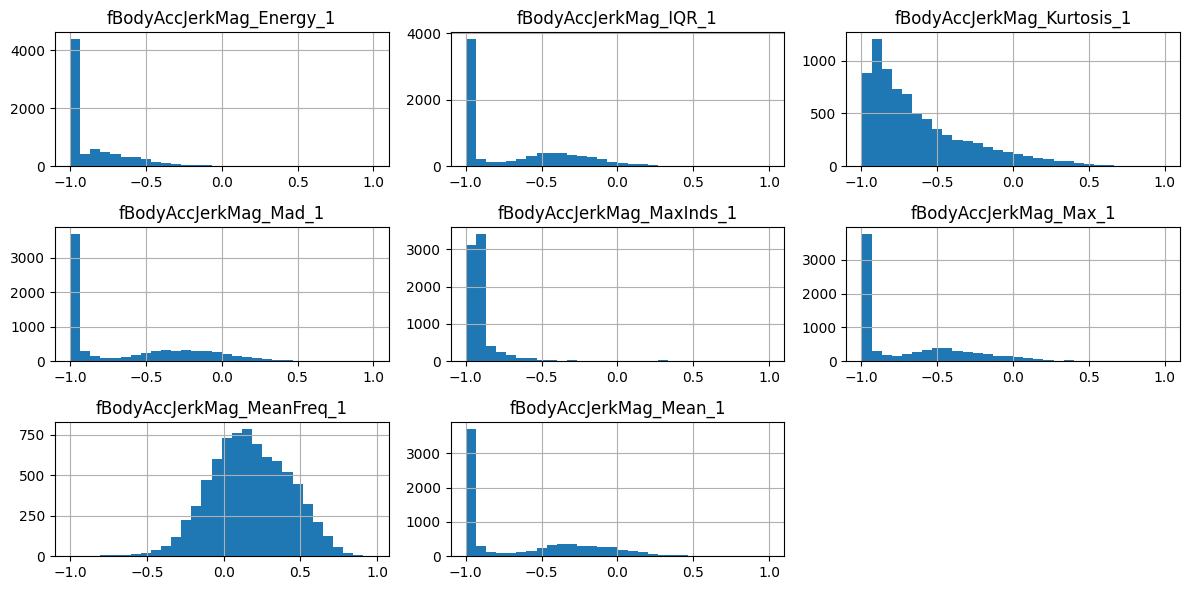

In [39]:
plt.figure(figsize=(8,5))
sns.countplot(y=y_train.map(label_map))
plt.title('Train class distribution')
plt.show()

X_train.iloc[:, :8].hist(bins=30, figsize=(12,6))
plt.tight_layout()
plt.show()

## 7) Preprocessing: scaler fit on train only
We will create a scaler and save it. For tree-based models scaling is not required, but KNN and Logistic require scaling. For safe CV use pipelines (scaler inside pipeline).

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)   # fit only on training data
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# os.makedirs('models', exist_ok=True)
# joblib.dump(scaler, 'models/scaler_train.joblib')
# print('saved scaler to models/scaler_train.joblib')

print('scaler fitted; shapes:', X_train_scaled.shape, X_test_scaled.shape)

saved scaler to models/scaler_train.joblib
scaler fitted; shapes: (7767, 561) (3162, 561)


## 8) Baseline models (train on full train set, evaluate on test set once)
We will evaluate Dummy, Logistic (with scaling), and a quick KNN baseline pipeline (scaling inside pipeline).

In [41]:
def evaluate_final(model, X_test_df, y_test_true, name='model'):
    y_pred = model.predict(X_test_df)
    # convert 0-based preds back to 1-based if ground truth is 1-based
    try:
        if y_test_true is not None and y_pred.min() == 0 and y_test_true.min() >= 1:
            y_pred = (y_pred + 1).astype(int)
    except Exception:
        # fallback: ensure ints
        y_pred = y_pred.astype(int)
    print('---', name)
    print('Accuracy:', accuracy_score(y_test_true, y_pred))
    print('Macro F1:', f1_score(y_test_true, y_pred, average='macro'))
    print(classification_report(y_test_true, y_pred, zero_division=0))
        
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(dummy, X_test, y_test, name='Dummy (most frequent)')

pipe_lr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1200, class_weight='balanced'))])
pipe_lr.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(pipe_lr, X_test, y_test, name='LogisticRegression (pipeline)')

pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])
pipe_knn.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(pipe_knn, X_test, y_test, name='KNN (k=5, pipeline)')

--- Dummy (most frequent)
Accuracy: 0.16065781151170144
Macro F1: 0.023069936421435056
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       496
           2       0.00      0.00      0.00       471
           3       0.00      0.00      0.00       420
           4       0.16      1.00      0.28       508
           5       0.00      0.00      0.00       556
           6       0.00      0.00      0.00       545
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        32
          10       0.00      0.00      0.00        25
          11       0.00      0.00      0.00        49
          12       0.00      0.00      0.00        27

    accuracy                           0.16      3162
   macro avg       0.01      0.08      0.02      3162
weighted avg       0.03      0.16      0.04      3162

--- LogisticRegression (pipeline)
Accuracy: 0.

## 9) Required models: RandomForest & XGBoost (train on full train set; tuning template below)
Train a quick default RF and XGBoost, then use CV on train for hyperparameter search (do not use test for tuning).

In [42]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(rf, X_test, y_test, name='RandomForest (quick)')

n_classes = y_train.nunique()
xgb_clf = xgb.XGBClassifier(objective='multi:softprob', num_class=n_classes, use_label_encoder=False,
                            eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)
xgb_clf.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(xgb_clf, X_test, y_test, name='XGBoost (quick)')

--- RandomForest (quick)
Accuracy: 0.9177735610373181
Macro F1: 0.8431890852324684
              precision    recall  f1-score   support

           1       0.90      0.97      0.94       496
           2       0.89      0.92      0.91       471
           3       0.96      0.84      0.90       420
           4       0.91      0.89      0.90       508
           5       0.90      0.93      0.91       556
           6       1.00      1.00      1.00       545
           7       0.84      0.70      0.76        23
           8       0.91      1.00      0.95        10
           9       0.71      0.75      0.73        32
          10       0.74      0.68      0.71        25
          11       0.76      0.69      0.72        49
          12       0.72      0.67      0.69        27

    accuracy                           0.92      3162
   macro avg       0.85      0.84      0.84      3162
weighted avg       0.92      0.92      0.92      3162

--- XGBoost (quick)
Accuracy: 0.9234661606578115
M

## 10) CatBoost (quick run & tuning template)
CatBoost often performs well out-of-the-box. If CatBoost is not installed, install it with pip.

In [43]:
if CatBoostClassifier is None:
    print('CatBoost not installed. Install via `pip install catboost` to run CatBoost cells.')
else:
    cb = CatBoostClassifier(iterations=500, learning_rate=0.1, random_seed=RANDOM_STATE, verbose=0)
    cb.fit(X_train, y_train_model)
    if y_test is not None:
        evaluate_final(cb, X_test, y_test, name='CatBoost (quick)')

    # tuning template (commented) - DO tuning on train only using CV
    # param_dist_cb = {
    #     'depth': [4,6,8],
    #     'learning_rate': [0.01, 0.05, 0.1],
    #     'iterations': [200, 500]
    # }
    # rnd_cb = RandomizedSearchCV(CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0),
    #                            param_distributions=param_dist_cb, n_iter=6, scoring='f1_macro', cv=StratifiedKFold(4), verbose=1)
    # rnd_cb.fit(X_train, y_train)
    # best_cb = rnd_cb.best_estimator_
    # evaluate_final(best_cb, X_test, y_test, name='CatBoost (tuned)')

--- CatBoost (quick)
Accuracy: 0.9209361163820367
Macro F1: 0.8508835673148143
              precision    recall  f1-score   support

           1       0.93      0.97      0.95       496
           2       0.90      0.94      0.92       471
           3       0.97      0.89      0.93       420
           4       0.92      0.84      0.88       508
           5       0.87      0.93      0.90       556
           6       1.00      1.00      1.00       545
           7       0.82      0.78      0.80        23
           8       1.00      0.90      0.95        10
           9       0.76      0.88      0.81        32
          10       0.68      0.76      0.72        25
          11       0.80      0.67      0.73        49
          12       0.71      0.56      0.62        27

    accuracy                           0.92      3162
   macro avg       0.86      0.84      0.85      3162
weighted avg       0.92      0.92      0.92      3162



## 11) KNN tuning (GridSearch template) — remember to use pipeline so scaler is fit inside CV folds

In [ ]:
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
param_grid_knn = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__weights': ['uniform','distance'],
}
cv_knn = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring='f1_macro', cv=cv_knn, n_jobs=-1, verbose=1)

# NOTE: uncomment to run full grid search (can take some time)
# gs_knn.fit(X_train, y_train)
# print('best knn', gs_knn.best_params_, gs_knn.best_score_)
# best_knn = gs_knn.best_estimator_
# evaluate_final(best_knn, X_test, y_test, name='KNN (tuned)')

print('KNN tuning template ready. Uncomment fit() lines to run grid search.')

KNN tuning template ready. Uncomment fit lines to run grid search.


## 12) Hyperparameter tuning template for RandomForest/XGBoost (use train only)
Use StratifiedKFold on training data. Do NOT use test data for tuning.

In [45]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

# RandomForest randomized search template
param_dist_rf = {
    'n_estimators': [100,200,400],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [1,2,4]
}
rnd_rf = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
                          param_distributions=param_dist_rf, n_iter=10, scoring='f1_macro', cv=cv, verbose=1, random_state=RANDOM_STATE)

# XGBoost randomized search template
param_dist_xgb = {
    'n_estimators': [100,200,400],
    'max_depth': [3,6,8],
    'learning_rate': [0.01, 0.05, 0.1]
}
rnd_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective='multi:softprob', num_class=n_classes, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1),
                           param_distributions=param_dist_xgb, n_iter=10, scoring='f1_macro', cv=cv, verbose=1, random_state=RANDOM_STATE)

print('Tuning templates ready. Uncomment fit() calls below to run on training data only.')
# Examples:
# rnd_rf.fit(X_train, y_train)
# best_rf = rnd_rf.best_estimator_
# evaluate_final(best_rf, X_test, y_test, name='RandomForest (tuned)')

# rnd_xgb.fit(X_train, y_train)
# best_xgb = rnd_xgb.best_estimator_
# evaluate_final(best_xgb, X_test, y_test, name='XGBoost (tuned)')

Tuning templates ready. Uncomment fit() calls below to run on training data only.


## 13) SHAP interpretation (template)
Use SHAP on a trained tree model (RF, XGB, CatBoost). Use a sample for speed.

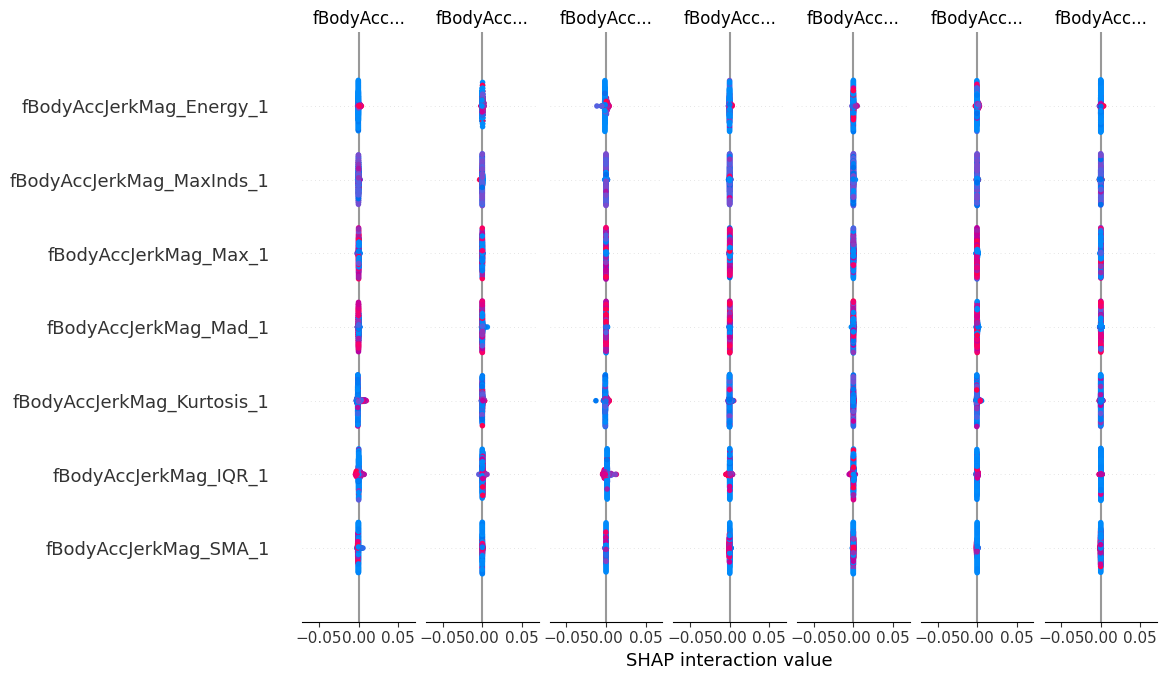

In [46]:
try:
    import shap
except Exception as e:
    print('shap not available:', e)
    shap = None

model_for_shap = None
if 'best_rf' in globals():
    model_for_shap = globals()['best_rf']
elif 'rf' in globals():
    model_for_shap = rf
elif 'best_xgb' in globals():
    model_for_shap = globals()['best_xgb']
elif 'xgb_clf' in globals():
    model_for_shap = xgb_clf
elif 'cb' in globals() and CatBoostClassifier is not None:
    model_for_shap = cb

if shap is not None and model_for_shap is not None and X_test.shape[0] > 0:
    sample_idx = np.random.choice(X_test.shape[0], min(300, X_test.shape[0]), replace=False)
    Xshap = X_test.iloc[sample_idx]
    try:
        explainer = shap.TreeExplainer(model_for_shap)
        shap_values = explainer.shap_values(Xshap)
        shap.summary_plot(shap_values, Xshap)
    except Exception as e:
        print('SHAP TreeExplainer error:', e)
else:
    print('SHAP not run: shap or model not available, or test set empty.')

## 14) Ablation experiments templates
Examples: time vs freq features; accel-only vs gyro-only; feature selection via permutation importance / RFECV.

In [47]:
# Example: time vs frequency domain features (based on column name prefixes)
time_cols = [c for c in X_train.columns if c.startswith('t')]
freq_cols = [c for c in X_train.columns if c.startswith('f')]
print('time:', len(time_cols), 'freq:', len(freq_cols))

def quick_rf_on(cols, name):
    if len(cols) == 0:
        print('No cols for', name); return
    rf_tmp = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
    rf_tmp.fit(X_train[cols], y_train_model)
    if y_test is not None:
        ypred = rf_tmp.predict(X_test[cols])
        # map preds back to 1-based for scoring
        if ypred.min() == 0:
            ypred = (ypred + 1).astype(int)
        print('\n--', name, 'Macro F1:', f1_score(y_test, ypred, average='macro'))
    return rf_tmp

rf_time = quick_rf_on(time_cols, 'RF on time')
rf_freq = quick_rf_on(freq_cols, 'RF on freq')
rf_both = quick_rf_on(time_cols + freq_cols, 'RF on combined')

time: 272 freq: 289

-- RF on time Macro F1: 0.8289772879143663

-- RF on freq Macro F1: 0.7171028958636146

-- RF on combined Macro F1: 0.8433834823753016


## 15) Train final chosen models on full train and evaluate on test (example)
After you tune hyperparameters using CV on the training set, re-fit the best estimator on the full training set and evaluate once on the test set. The examples below show fitting default models; replace with tuned models when ready.

In [48]:
final_rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
final_rf.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(final_rf, X_test, y_test, name='RandomForest (final)')

final_xgb = xgb.XGBClassifier(objective='multi:softprob', num_class=n_classes, use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE, n_jobs=-1)
final_xgb.fit(X_train, y_train_model)
if y_test is not None:
    evaluate_final(final_xgb, X_test, y_test, name='XGBoost (final)')

if CatBoostClassifier is not None:
    final_cb = CatBoostClassifier(iterations=500, learning_rate=0.05, random_seed=RANDOM_STATE, verbose=0)
    final_cb.fit(X_train, y_train_model)
    if y_test is not None:
        evaluate_final(final_cb, X_test, y_test, name='CatBoost (final)')
else:
    print('CatBoost not available; skip final CatBoost training.')

# KNN final example
try:
    if 'best_knn' in globals():
        best_knn.fit(X_train, y_train_model)
        if y_test is not None:
            evaluate_final(best_knn, X_test, y_test, name='KNN (final tuned)')
    else:
        knn_quick = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance'))])
        knn_quick.fit(X_train, y_train_model)
        if y_test is not None:
            evaluate_final(knn_quick, X_test, y_test, name='KNN (final quick)')
except Exception as e:
    print('KNN final eval error:', e)

--- RandomForest (final)
Accuracy: 0.9177735610373181
Macro F1: 0.8431890852324684
              precision    recall  f1-score   support

           1       0.90      0.97      0.94       496
           2       0.89      0.92      0.91       471
           3       0.96      0.84      0.90       420
           4       0.91      0.89      0.90       508
           5       0.90      0.93      0.91       556
           6       1.00      1.00      1.00       545
           7       0.84      0.70      0.76        23
           8       0.91      1.00      0.95        10
           9       0.71      0.75      0.73        32
          10       0.74      0.68      0.71        25
          11       0.76      0.69      0.72        49
          12       0.72      0.67      0.69        27

    accuracy                           0.92      3162
   macro avg       0.85      0.84      0.84      3162
weighted avg       0.92      0.92      0.92      3162

--- XGBoost (final)
Accuracy: 0.9234661606578115
M

In [ ]:
"""
## 16) Save final models and scaler
"""
# os.makedirs('models', exist_ok=True)
# joblib.dump(final_rf, 'models/final_rf.joblib')
# joblib.dump(final_xgb, 'models/final_xgb.joblib')
# if 'final_cb' in globals():
#     joblib.dump(final_cb, 'models/final_catboost.joblib')
# joblib.dump(scaler, 'models/scaler.joblib')
# print('saved models and scaler to models/')
print('Models kept in variables (final_rf, final_xgb, etc). Saving disabled.')

saved models and scaler to models/


In [50]:
"""
## 17) If test has no labels: produce submission file
If your provided test set is unlabeled, predict and save the results for submission or reporting.
"""
if y_test is None:
    preds_model = final_rf.predict(X_test)
    # convert to 1-based
    preds = (preds_model + 1).astype(int)
    out = pd.DataFrame({'id': X_test.index, 'activity': preds})
    out.to_csv('preds_final_rf.csv', index=False)
    print('Saved preds_final_rf.csv')
else:
    print('Test labels available; predictions already evaluated above.')

Test labels available; predictions already evaluated above.


## 18) Notes for the report & reproducibility
- All preprocessing (scaler, dropped constant columns) must be applied identically to test. We saved the scaler and models in models/.
- Perform hyperparameter tuning using only the training set (use StratifiedKFold). Do not touch the test set during tuning.
- Report final metrics (accuracy, macro-F1, per-class precision/recall/F1, confusion matrix) computed once on the test set.
- Include a contributions section naming who implemented each part of the notebook and the report.

If you want, I can now:
1) Fill tuning runs (uncomment fit() calls) with moderate param ranges so the notebook will do automated tuning (will take time), or
2) Produce a compressed version that runs quickly with small n_estimators / reduced folds for quick feedback.

Which do you prefer?